<a href="https://colab.research.google.com/gist/proppy/b8a35e01e22c9685a79fa144e0df3f36/zerotoasic_project1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:32
🔁 Restarting kernel...


In [4]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [50]:
!gsutil cp -r gs://proppy-eda/conda-repo .
!conda install -c file://content/conda-repo/ --yes magic open_pdks.sky130a gdstk ngspice-lib
!pip install cairosvg pyspice

Copying gs://proppy-eda/conda-repo/channeldata.json...
Copying gs://proppy-eda/conda-repo/index.html...
Copying gs://proppy-eda/conda-repo/linux-64/.cache/about/magic-8.3.266_0000_g6ecd077-20220203_1935.tar.bz2.json...
Copying gs://proppy-eda/conda-repo/linux-64/.cache/index/magic-8.3.266_0000_g6ecd077-20220203_1935.tar.bz2.json...
/ [4 files][  9.2 KiB/  9.2 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://proppy-eda/conda-repo/linux-64/.cache/paths/magic-8.3.266_0000_g6ecd077-20220203_1935.tar.bz2.json...
Copying gs://proppy-eda/conda-repo/linux-64/.cache/post_install/magic-8.3.266_0000_g6ecd077-20220203_1935.tar.bz2.json...
Copying gs://proppy-eda/conda-repo/linux-64/.cache/recipe/magic-8.3.266_0000_g6ecd077-20220203_1

In [64]:
%%script bash -c "PDK_ROOT=/usr/local/share/pdk/sky130A PDKPATH=/usr/local/share/pdk/sky130A magic -dnull -noconsole -rcfile /usr/local/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc"
cellname rename mosfet

box 0 0 950nm 650nm
paint ndiffusion

box 400nm -600nm 550nm 1200nm
paint polysilicon

box 0 0 400nm 650nm
label source
port make 3

box 550nm 0 950nm 650nm
label drain
port make 1

box 400nm -600nm 550nm 0
label gate
port make 2

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write mosfet.gds


Magic 8.3 revision 266 - Compiled on Sat Feb 12 12:14:27 PM JST 2022.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(vendor): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    mvobsactive ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.283-0-g7519dfb
Root cell box:
           width x height  (   llx,  lly  ), (   urx,  ury  )  area (units^2)

microns:   0.950 x 0.650   ( 0.000,  0.000), ( 0.950,  0.650)  0.618     
lambda:    95.00 x 65.00   (  0.00,  0.00 ), ( 95.00,  65.00)  6175.00   
internal:    190 x 130     (     0,  0    ), (   190,  130  )  24700     
Root cell box:
           width x height  (   llx,  lly  ), (   urx

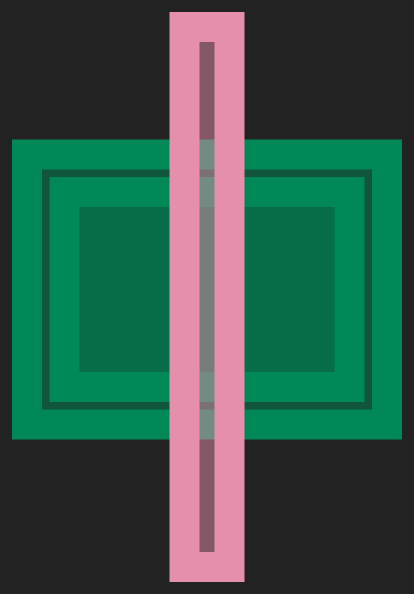

In [56]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('mosfet.gds')
top_cells = library.top_level()
top_cells[0].write_svg('mosfet.svg')
cairosvg.svg2png(url='mosfet.svg', write_to='mosfet.png', scale=30.0)
Image('mosfet.png')

.title mosfet0
.include /content/mosfet.spice
.lib /usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice tt
Xmosfet0 DRAIN GATE VGND mosfet
Vgnd VGND 0 0
Vdd VPWR VGND 1.8
R VPWR DRAIN 10k
VVin GATE VGND DC 0V PULSE(0V 1.8V 1ns 10ps 10ps 1ns 2ns)

done


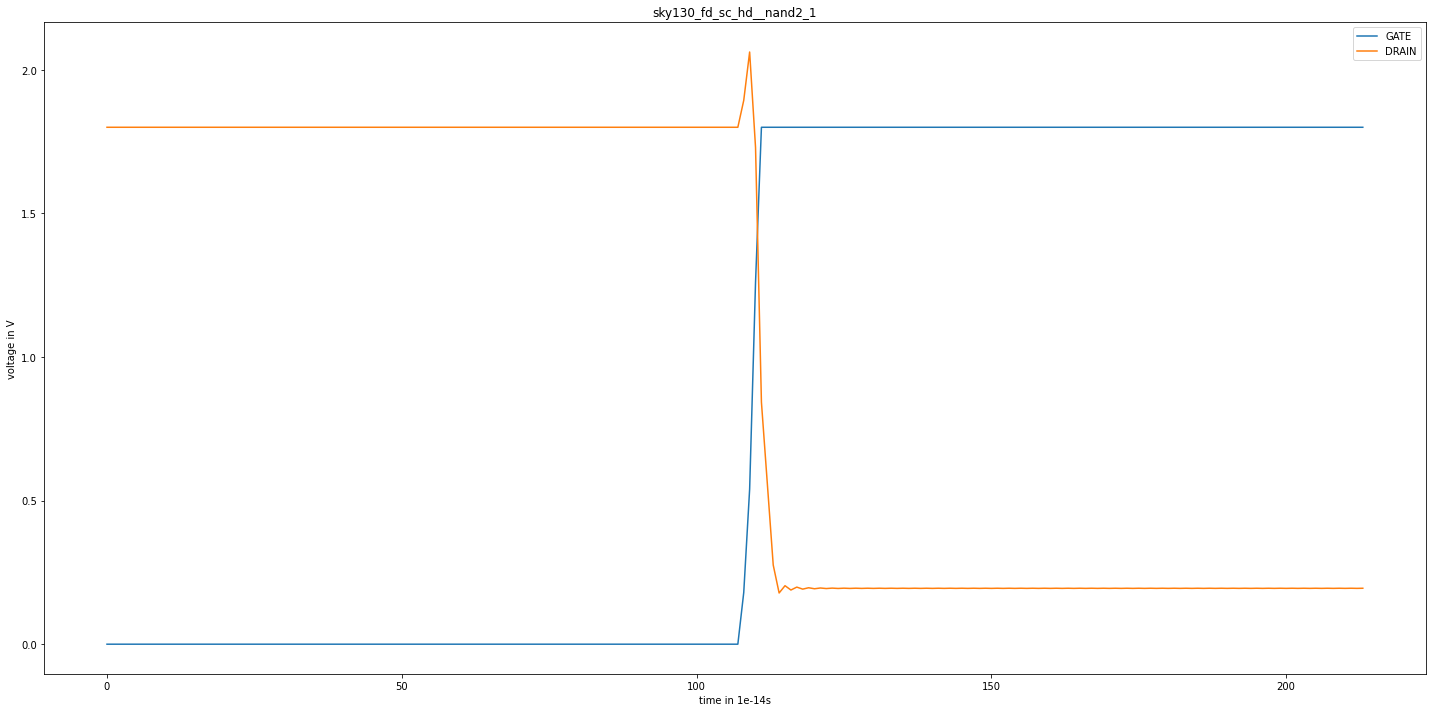

In [80]:
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *
import matplotlib.pyplot as plt

circuit = Circuit('mosfet0')
circuit.lib('/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice', 'tt')
circuit.include('mosfet.spice')
circuit.X('mosfet0', 'mosfet', 'DRAIN', 'GATE', 'VGND')
circuit.V('gnd', 'VGND', 0, 0)
circuit.V('dd', 'VPWR', 'VGND', 1.8)
circuit.R('', 'VPWR', 'DRAIN', '10k')
circuit.PulseVoltageSource('Vin', 'GATE', 'VGND',
                           initial_value=0@u_V, pulsed_value=1.8@u_V,
                           rise_time=10@u_ps, fall_time=10@u_ps,
                           pulse_width=1@u_ns, period=2@u_ns, delay_time=1@u_ns)
print(str(circuit))
simulator = circuit.simulator()
analysis = simulator.transient(step_time=10@u_ps, end_time=2@u_ns)
print('done')
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('sky130_fd_sc_hd__nand2_1')
ax.set_xlabel('time in 1e-14s')
ax.set_ylabel('voltage in V')
ax.plot(analysis.GATE)
ax.plot(analysis.DRAIN)
ax.legend(('GATE', 'DRAIN'))
plt.tight_layout()
plt.show()